In [1]:
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import numpy as np
import seaborn as sns
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import optim

In [2]:
batch_size_train = 64
batch_size_test = 64

In [3]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
train_loader = torch.utils.data.DataLoader(
        torchvision.datasets.CIFAR10(root='./data', train=True, download=True,
                                   transform=transform), batch_size=batch_size_train, shuffle=True
    )
test_loader = torch.utils.data.DataLoader(
        torchvision.datasets.CIFAR10(root='./data', train=False, download=True,
                                   transform=transform), batch_size=batch_size_test, shuffle=False
    )

100%|██████████| 170M/170M [00:04<00:00, 34.7MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v3_large', weights="DEFAULT")
model.classifier.out_features = 10

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 72.6MB/s]


In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00003)

In [7]:
def train(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    accuracy = 100 * correct / total
    return running_loss / len(loader), accuracy

def test(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    return running_loss / len(loader), accuracy


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

num_epochs = 10

for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_accuracy = test(model, test_loader, criterion, device)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')


Epoch 1/10, Train Loss: 1.1772, Train Accuracy: 66.70%, Test Loss: 0.4051, Test Accuracy: 86.40%
Epoch 2/10, Train Loss: 0.3600, Train Accuracy: 87.83%, Test Loss: 0.2817, Test Accuracy: 90.26%
Epoch 3/10, Train Loss: 0.2353, Train Accuracy: 91.92%, Test Loss: 0.2444, Test Accuracy: 91.75%
Epoch 4/10, Train Loss: 0.1695, Train Accuracy: 94.14%, Test Loss: 0.2329, Test Accuracy: 92.42%
Epoch 5/10, Train Loss: 0.1198, Train Accuracy: 95.98%, Test Loss: 0.2215, Test Accuracy: 92.77%
Epoch 6/10, Train Loss: 0.0845, Train Accuracy: 97.07%, Test Loss: 0.2330, Test Accuracy: 92.63%
Epoch 7/10, Train Loss: 0.0609, Train Accuracy: 97.91%, Test Loss: 0.2288, Test Accuracy: 93.34%
Epoch 8/10, Train Loss: 0.0432, Train Accuracy: 98.57%, Test Loss: 0.2598, Test Accuracy: 92.93%
Epoch 9/10, Train Loss: 0.0312, Train Accuracy: 99.05%, Test Loss: 0.2668, Test Accuracy: 93.37%
Epoch 10/10, Train Loss: 0.0256, Train Accuracy: 99.20%, Test Loss: 0.2794, Test Accuracy: 93.11%


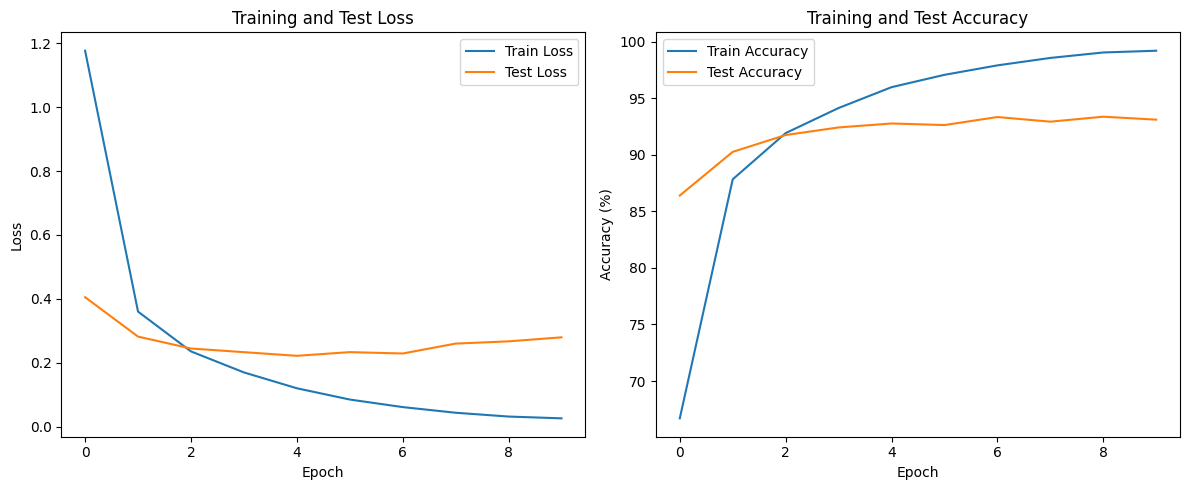

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


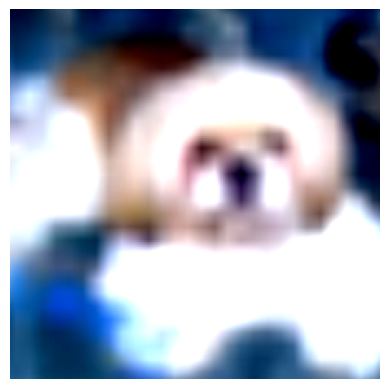

Predicted: 5, Actual: 5


In [ ]:
def imshow(img):
    img = img / 2 + 0.5
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.axis('off')
    plt.show()

def test_random_image(model, loader, device):
    model.eval()
    images, labels = next(iter(loader))
    images, labels = images.to(device), labels.to(device)

    import random
    index = random.randint(0, images.size(0) - 1)
    image = images[index].unsqueeze(0)
    label = labels[index].item()

    output = model(image)
    _, predicted = torch.max(output, 1)
    predicted = predicted.item()

    imshow(image.cpu().squeeze())
    print(f'Predicted: {predicted}, Actual: {label}')

test_random_image(model, test_loader, device)

In [10]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v3_large', pretrained=False)
model.classifier.out_features = 10

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

num_epochs = 10

for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_accuracy = test(model, test_loader, criterion, device)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')


Epoch 1/10, Train Loss: 6.9057, Train Accuracy: 0.07%, Test Loss: 6.9078, Test Accuracy: 0.02%
Epoch 2/10, Train Loss: 6.9056, Train Accuracy: 0.05%, Test Loss: 6.9082, Test Accuracy: 0.02%
Epoch 3/10, Train Loss: 6.9057, Train Accuracy: 0.05%, Test Loss: 6.9078, Test Accuracy: 0.00%
Epoch 4/10, Train Loss: 6.9057, Train Accuracy: 0.07%, Test Loss: 6.9079, Test Accuracy: 0.00%
Epoch 5/10, Train Loss: 6.9057, Train Accuracy: 0.05%, Test Loss: 6.9080, Test Accuracy: 0.00%
Epoch 6/10, Train Loss: 6.9057, Train Accuracy: 0.07%, Test Loss: 6.9078, Test Accuracy: 0.00%
Epoch 7/10, Train Loss: 6.9057, Train Accuracy: 0.07%, Test Loss: 6.9078, Test Accuracy: 0.01%
Epoch 8/10, Train Loss: 6.9057, Train Accuracy: 0.06%, Test Loss: 6.9080, Test Accuracy: 0.00%
Epoch 9/10, Train Loss: 6.9056, Train Accuracy: 0.07%, Test Loss: 6.9076, Test Accuracy: 0.00%
Epoch 10/10, Train Loss: 6.9057, Train Accuracy: 0.05%, Test Loss: 6.9078, Test Accuracy: 0.00%


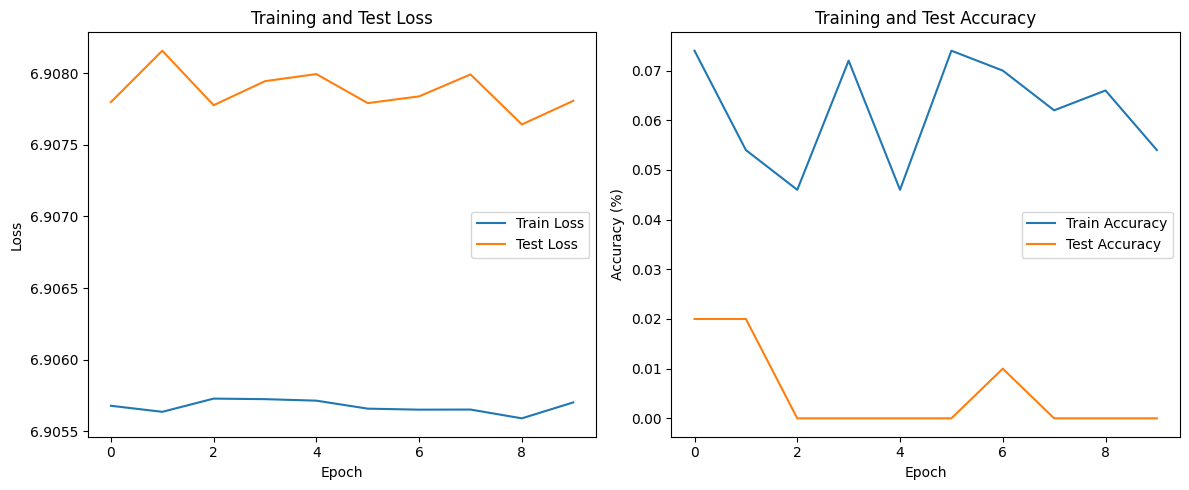

In [12]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


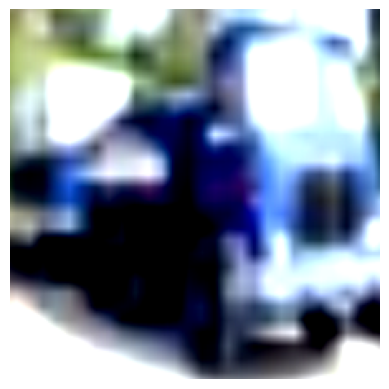

Predicted: 683, Actual: 9


In [13]:
def imshow(img):
    img = img / 2 + 0.5
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.axis('off')
    plt.show()

def test_random_image(model, loader, device):
    model.eval()
    images, labels = next(iter(loader))
    images, labels = images.to(device), labels.to(device)

    import random
    index = random.randint(0, images.size(0) - 1)
    image = images[index].unsqueeze(0)
    label = labels[index].item()

    output = model(image)
    _, predicted = torch.max(output, 1)
    predicted = predicted.item()

    imshow(image.cpu().squeeze())
    print(f'Predicted: {predicted}, Actual: {label}')

test_random_image(model, test_loader, device)